In [93]:

import numpy as np

from logic import GeoPointToXY, Point, MotionConstraints, SpeedPredictor, PumpController, PumpConstraints, \
    BoundaryAction, GeoPoint, PolylineSampler, polyline_lengths, PureLateralLimitTurnPolicy, point_on_path, Polygon

# Парсинг данных

## Вспомогательные функции

In [94]:
def plot_polygon(polygon: Polygon):
    points = polygon.vertices
    pts = list(points)
    if pts[0] != pts[-1]:
        pts = pts + [pts[0]]  # замыкаем для отображения

    xs, ys = zip(*pts)
    plt.figure()
    plt.fill(xs, ys, alpha=0.3, edgecolor="black", linewidth=1.5)
    plt.plot(xs, ys, "o-", color="black")

    # координаты центра тяжести (среднее по вершинам для подписи)
    cx, cy = sum(x for x, _ in points) / len(points), sum(y for _, y in points) / len(points)

    ha = 100 * 100 # 1Га = 100м x 100 м = 10'000 м^2
    area = polygon.area
    plt.text(cx, cy, f"Area = {area / ha :.2f} Га", ha="center", va="center", fontsize=12, weight="bold")
    plt.axis("equal")
    plt.show()

### Парсинг плана миссии

In [95]:
def parse_key_points_from_qgc_plan(plan: dict,
                                   include_home: bool = True,
                                   include_takeoff: bool = True,
                                   include_polygon: bool = True,
                                   include_transects: bool = True,
                                   deduplicate: bool = True) -> list[GeoPoint]:
    """
    Извлекает ключевые точки из QGC .plan:
      - plannedHomePosition
      - SimpleItem command=22 (взлёт) → params[4]=lat, params[5]=lon
      - ComplexItem 'survey' → polygon [[lat, lon], ...], старт с entryLocation (1-based)
      - ComplexItem 'survey' → TransectStyleComplexItem.VisualTransectPoints [[lat, lon], ...]
      - SimpleItem с coordinate (если есть)
    Возвращает GeoPointDTO(lon, lat, speed=0.0).
    """
    mission = plan.get("mission", {})
    items = mission.get("items", []) or []

    pts: list[GeoPoint] = []

    def add(lat: Optional[float], lon: Optional[float]):
        if lat is None or lon is None:
            return
        pts.append(GeoPoint(lon=float(lon), lat=float(lat)))

    # 1) Home
    if include_home:
        php = mission.get("plannedHomePosition")
        if isinstance(php, list) and len(php) >= 2:
            add(float(php[0]), float(php[1]))

    # 2) Takeoff (command 22)
    if include_takeoff:
        for it in items:
            if it.get("type") == "SimpleItem" and it.get("command") == 22:
                params = it.get("params", [])
                if isinstance(params, list) and len(params) >= 7:
                    add(float(params[4]), float(params[5]))
                break

    # 3,4) Survey polygon + VisualTransectPoints
    for it in items:
        if it.get("type") == "ComplexItem" and it.get("complexItemType") == "survey":
            if include_polygon:
                poly = it.get("polygon") or []
                verts: list[tuple[float, float]] = []
                for p in poly:
                    if isinstance(p, (list, tuple)) and len(p) >= 2:
                        verts.append((float(p[0]), float(p[1])))  # [lat, lon]
                if verts:
                    entry = it.get("entryLocation")
                    start = (entry - 1) if isinstance(entry, int) and 1 <= entry <= len(verts) else 0
                    ordered = verts[start:] + verts[:start]
                    for lat, lon in ordered:
                        add(lat, lon)
            if include_transects:
                tsc = it.get("TransectStyleComplexItem", {})
                vtp = tsc.get("VisualTransectPoints") or []
                for p in vtp:
                    if isinstance(p, (list, tuple)) and len(p) >= 2:
                        add(float(p[0]), float(p[1]))  # [lat, lon]
            break

    # 5) Прочие SimpleItem с coordinate
    for it in items:
        if it.get("type") == "SimpleItem":
            coord = it.get("coordinate")
            if isinstance(coord, list) and len(coord) >= 2:
                add(float(coord[0]), float(coord[1]))

    # 6) Дедупликация (по lat/lon)
    if deduplicate and pts:
        seen = set()
        uniq: list[GeoPoint] = []
        for p in pts:
            key = (round(p.lat, 8), round(p.lon, 8))
            if key in seen:
                continue
            seen.add(key)
            uniq.append(p)
        pts = uniq

    return pts


In [96]:
from pathlib import Path
from typing import Optional
import csv


# ====== Парсер CSV с ';' и десятичной ',' ======
def _to_float(s: str) -> Optional[float]:
    """Безопасное превращение строки с десятичной ',' в float. Пустые -> None."""
    if s is None:
        return None
    s = s.strip()
    if not s:
        return None
    # заменяем десятичную запятую на точку
    s = s.replace(',', '.')
    try:
        return float(s)
    except ValueError:
        return None


def parse_points_csv(
        path: Path,
        *,
        lat_col: int = 20,  # c20
        lon_col: int = 21,  # c21
        speed_col: int = 1  # c1 (текущая горизонтальная скорость)
) -> list[dict]:
    """
    Читает CSV и возвращает список PointDTO:
    - разделитель ';'
    - десятичная запятая ','
    - координаты берём из c20/c21 (lon/lat), скорость из c1
    - проекция: локальная AEQD вокруг первой валидной точки
    """
    # Сначала собираем геоточки
    geo_points = []
    with open(path, 'r', encoding='utf-8', newline='') as f:
        reader = csv.reader(f, delimiter=';')
        for row in reader:
            # пропускаем пустые/короткие строки
            if not row or len(row) <= max(lon_col, lat_col, speed_col):
                continue
            lon = _to_float(row[lon_col])
            lat = _to_float(row[lat_col])
            speed = _to_float(row[speed_col])
            if lon is None or lat is None or speed is None:
                continue
            geo_points.append(dict(lon=lon, lat=lat, speed=speed))

    if not geo_points:
        # честно сообщаем о проблеме входных данных
        raise ValueError("Не найдено ни одной валидной строки c lon/lat/speed в заданных столбцах.")

    return geo_points


In [97]:
def scatter_with_color(p: list[Point], points_values: list[float], label="Скорость, м/с", cmap='viridis') -> None:
    xs, ys = zip(*p)
    sc = plt.scatter(xs, ys, c=points_values, cmap=cmap)
    plt.plot(xs, ys, '--')
    cbar = plt.colorbar(sc, fraction=0.1, pad=0.02)
    cbar.set_label(label)

In [98]:
def scatter_with_color_and_profile(p: list[Point], points_values: list[float], cmap='viridis', scatter_size=10) -> None:
    fig, (ax1, ax2) = plt.subplots(2, 1)

    path_x, path_y = zip(*p)
    sc = ax1.scatter(path_x, path_y, c=points_values, cmap=cmap, s=scatter_size)

    ax1.plot(path_x, path_y, linestyle="--", color="gray", alpha=0.3)
    ax1.set_xlabel("X, м")
    ax1.set_ylabel("Y, м")
    ax1.set_title("Траектория полёта (цвет = скорость, м/с)")
    fig.colorbar(sc, ax=ax1, label="скорость, м/с")

    ax2.plot(polyline_lengths(p), points_values, label="Скорость, м/с")
    ax2.set_xlabel("длина пути, м")
    ax2.set_ylabel("скорость, м/с")
    ax2.set_title("Профиль")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [99]:
import matplotlib.pyplot as plt
from typing import Optional

def plot_at_ax_scatter_with_color_and_empty(
    ax,
    p: list[Point],
    points_values: list[float],
    empty_s_list: list[float],
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
    title: Optional[str] = None,
) -> None:
    xs, ys = zip(*p)

    sc = ax.scatter(xs, ys, c=points_values, cmap='viridis', label='траектория')
    ax.plot(xs, ys, '--', color="gray")

    # колорбар
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label("values")

    # отмечаем empty
    if empty_s_list:
        empty_points = [point_on_path(p, e) for e in empty_s_list]
        xe, ye = zip(*empty_points)
        ax.scatter(xe, ye, marker="x", s=40, color="red", label="empty")

    # подписи, если заданы
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)

    # ax.legend()


In [100]:
def plot_at_ax_profile_speeds(ax, s_list, v_pump, v_motion):
    ax.plot(s_list, v_pump, label="v_pump", linewidth=1)
    ax.set_ylabel("v_pump")

    # правая ось
    axr = ax.twinx()
    axr.plot(s_list, v_motion, label="v_motion", linewidth=1, linestyle="--")
    axr.set_ylabel("v_motion")

    # объединённая легенда
    lines, labels = [], []
    for a in (ax, axr):
        l, lab = a.get_legend_handles_labels()
        lines += l
        labels += lab

    ax.legend(lines, labels, loc="upper right")

    ax.set_xlabel("s (distance)")
    ax.grid(True, which="both", axis="both", linestyle=":", linewidth=0.5)

In [101]:
def plot_speeds_profile(points, s_list, v_pump, v_motion, empty_s_list):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    plot_at_ax_scatter_with_color_and_empty(ax1, points, v_motion, empty_s_list, title='v_motion')
    # plot_at_ax_scatter_with_color_and_empty(ax2, points, v_motion, empty_s_list)
    plot_at_ax_profile_speeds(ax2, s_list, v_pump, v_motion)
    # plot_at_ax_profile_speeds(ax4, s_list, v_pump, v_motion)
    plt.show()

## Загрузка данных

In [102]:
# path_to_file = Path(r"C:\Users\nodax\Downloads\Telegram Desktop\spraying_20250823_070453_421_bfb27ec8_e827_4223_b269_bcb6003c317d.json")
# path_to_file = Path(r"C:\Users\nodax\Downloads\Telegram Desktop\spraying_20250823_080917_583_5626d8a6_8846_42c3_9e83_fc623fa61e77.json")
# path_to_file = Path(r"C:\Users\nodax\Downloads\Telegram Desktop\spraying_20250823_065052_535_7b16fa90_a27b_4f52_909c_d1f86fe0404a.json")
path_to_file = Path(r"C:\Users\nodax\Downloads\Telegram Desktop\spraying_20250908_080420_485_24a89b48_9ecb_4956_bdb3_4d01f9de0f4a.json")

In [103]:
import json

with open(path_to_file, "r", encoding="utf-8") as f:
    data = json.load(f)

## Визуализация плана мисии

In [104]:
gp = parse_key_points_from_qgc_plan(
    data['mission']['mission_plan'],
    include_home=True,
    include_takeoff=False,
    include_polygon=False,
    include_transects=False,
    deduplicate=False,
)
[CENTER] = gp

In [105]:
def to_xy(p: GeoPoint) -> Point:
    return GeoPointToXY.geo_to_xy_eq(CENTER, p)

def to_geo(p: Point) -> GeoPoint:
    return GeoPointToXY.xy_to_geo_eq(CENTER, p)

def to_xy_points(gp: list[GeoPoint]) -> list[Point]:
    return [to_xy(p) for p in gp]
    # return [GeoPointToXY.geo_to_xy_aeqd(CENTER, p) for p in gp]
    # return [GeoPointToXY.geo_to_xy_utm(CENTER, p) for p in gp]

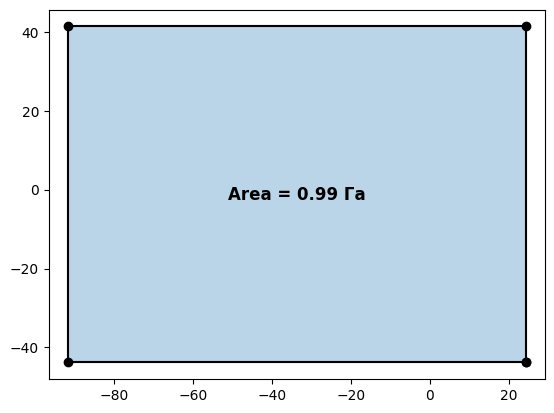

In [106]:
from logic import Polygon

gp = parse_key_points_from_qgc_plan(
    data['mission']['mission_plan'],
    include_home=False,
    include_takeoff=False,
    include_polygon=True,
    include_transects=False,
    deduplicate=False,
)
# переводим гео координаты в xy
polygon_plan_points: list[Point] = to_xy_points(gp)
plan_polygon = Polygon(polygon_plan_points)
plot_polygon(plan_polygon)

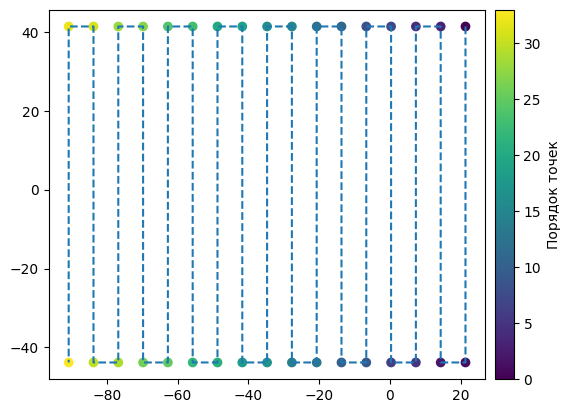

In [107]:
gp = parse_key_points_from_qgc_plan(
    data['mission']['mission_plan'],
    include_home=False,
    include_takeoff=False,
    include_polygon=False,
    include_transects=True,
    deduplicate=False,
)
# переводим гео координаты в xy
plan_points: list[Point] = to_xy_points(gp)
scatter_with_color(plan_points, list(range(len(plan_points))), 'Порядок точек')

## Визуализация Логов полётов

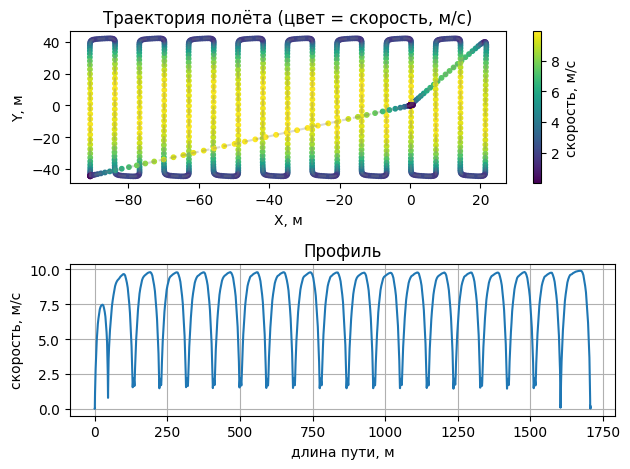

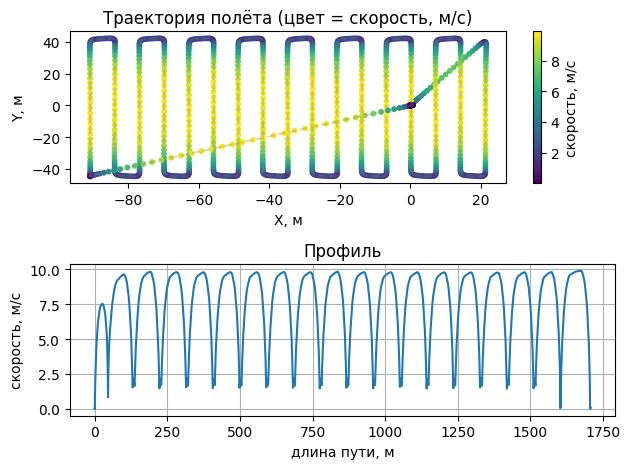

In [108]:
flights = data['flights']
points_by_flight = []

for f in flights:
    geo_points: list[GeoPoint] = []
    speed_list = []

    for s in f['samples']:
        if s['VehicleID'] != 1:
            continue
        telemetry = s['telemetry']
        p = telemetry['coordinate']
        geo_points.append(GeoPoint(lat=p['lat'], lon=p['lon']))
        speed_list.append(telemetry['speed']['groundSpeed'])

    # переводим гео координаты в xy
    points: list[Point] = to_xy_points(geo_points)

    scatter_with_color_and_profile(points, speed_list)

    plt.show()
    points_by_flight.append({'points': points, 'speed': speed_list})

In [109]:
arr = np.array(points_by_flight[0]['speed'])

## Предсказанный на основе плана

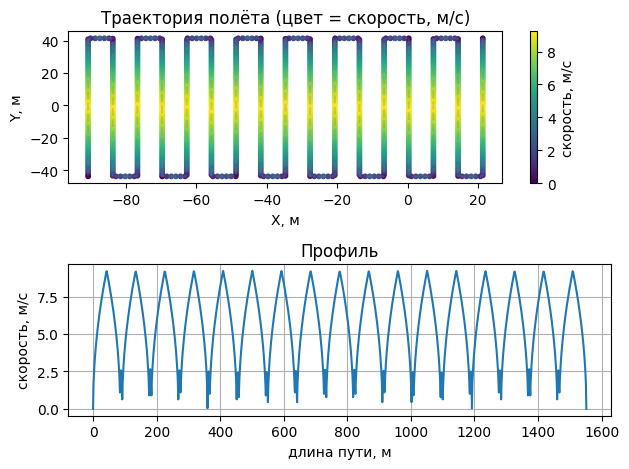

In [110]:
# waypoints = [Point(x,y) for x,y in ((0, 0), (20, 0), (50, 0), (50, 50), (100, 50))]
# waypoints = points_by_flight[0]['points']
waypoints = plan_points
motion = MotionConstraints(
    v_max=10.0,
    a_max=1.0,
    d_max=1.0,
    yaw_rate=90.0,
    turn_radius=0,
    a_lat_max=2.0,
    angle_eps_deg=10.0,
    start_speed=0.0,
    end_speed=0.0
)

predictor = SpeedPredictor(motion, PureLateralLimitTurnPolicy())
profile = predictor.build_profile(waypoints)

s_list = np.linspace(0, profile.total_distance, 1200)
points = [point_on_path(waypoints, d) for d in s_list]
scatter_with_color_and_profile(points, [profile.speed_at_distance(p) for p in s_list])

In [111]:
from logic import sqm_to_hectares

In [112]:
sqm_to_hectares(plan_polygon.area)

0.9894243750253751

Длина маршрута L = 1560.21 м
Плановый объём V_total = 79.15 л
Фактически выльется (с учётом ограничений насоса): 58.08 л
Бак не опустошается в ходе полёта.


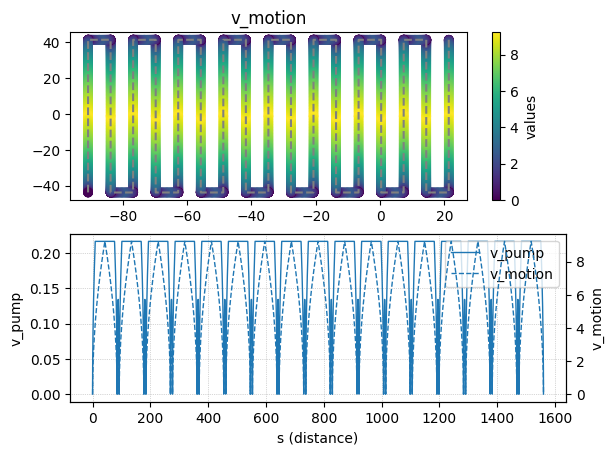

In [113]:
t_list, s_list, speed_list = profile.simulate_time_param(dt=0.1)

norma = 80 # Норма внесения Литры/Га
pump_min_speed = 1 # л/мин
pump_max_speed = 13 # л/мин
tank_volume = 400000 # л

V_total = norma * sqm_to_hectares(plan_polygon.area)  # л — нужно вылить на всём маршруте

constraints = PumpConstraints(
    q_min=pump_min_speed / 60,  # л/с
    q_max=pump_max_speed / 60,  # л/с
    tank_volume=tank_volume,  # л
    low_mode=BoundaryAction.CLAMP,
    high_mode=BoundaryAction.CLAMP,
)

pump = PumpController(constraints)

plan = pump.compute_flow_series(
    t=t_list,
    v_motion=speed_list,
    length=profile.total_distance,
    volume_total=V_total,
)

print(f"Длина маршрута L = {profile.total_distance :.2f} м")
print(f"Плановый объём V_total = {V_total:.2f} л")
print(f"Фактически выльется (с учётом ограничений насоса): {pump.total_dispensed(plan) :.2f} л")
empty_s_list = [profile.distance_at_time(t) for t, v in plan.empty_events]

if plan.empty_events:
    print("Моменты опустошения бака:")
    for (t_empty, V_cum), s in zip(plan.empty_events, empty_s_list):
        print(f"\tt = {t_empty:.2f} с, s = {s:.2f} м")
else:
    print("Бак не опустошается в ходе полёта.")

list_pts = [point_on_path(waypoints, s) for s in s_list]

plot_speeds_profile(list_pts,
                    s_list,
                    plan.q,
                    speed_list,
                    empty_s_list)

In [114]:
import numpy as np
from scipy import integrate

f = lambda t: plan.q[np.argmin(pow(np.array(plan.t)-t, 2))]
val, err = integrate.quad(f, 0.0, plan.t[-1])
print(val)  # ≈ 3.141592653589793
print(err)  # оценка погрешности, ~1e-14

57.985633493520204
0.3988936710494073


C:\Users\nodax\AppData\Local\Temp\ipykernel_11456\4268492361.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, err = integrate.quad(f, 0.0, plan.t[-1])


In [115]:
5.383143712454684 + 0.1948249115240701

5.577968623978754

## Предсказанный на основе логов

In [116]:
fly_no = 0
actual_points = points_by_flight[fly_no]['points']
speeds = points_by_flight[fly_no]['speed']

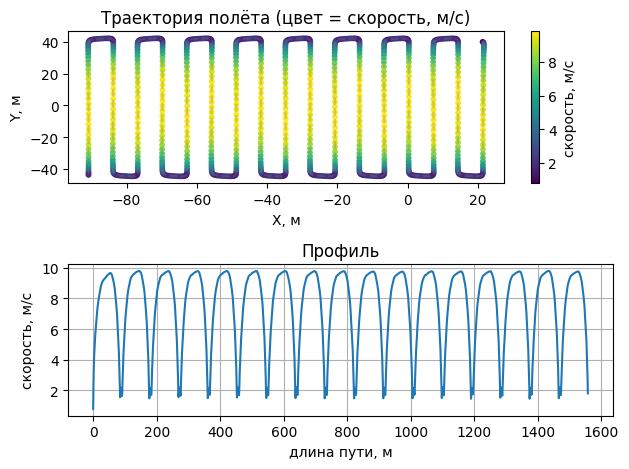

In [117]:
from logic import dist

start = np.argmin([dist(plan_points[0], p) for p in actual_points])
end = np.argmin([dist(plan_points[-1], p) for p in actual_points]) + 1

waypoints = actual_points[start:end]
speed_list = speeds[start:end]
s_list = polyline_lengths(waypoints)
scatter_with_color_and_profile(waypoints, speed_list)

Длина маршрута L = 1560.21 м
Плановый объём V_total = 6.93 л
Фактически выльется (с учётом ограничений насоса): 7.59 л
Бак не опустошается в ходе полёта.


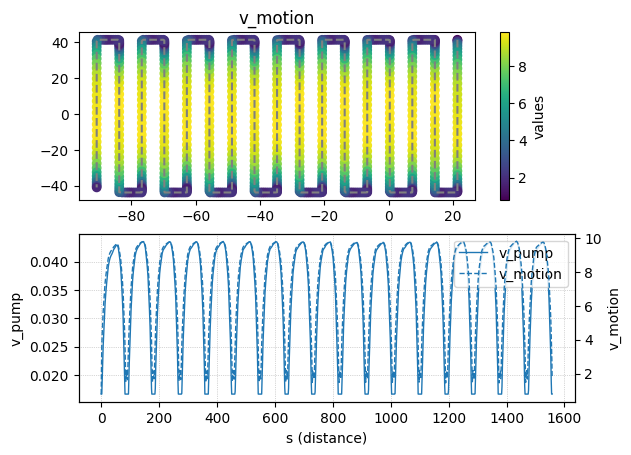

In [118]:
from logic import simulate_time_param

t_list = simulate_time_param(waypoints, speed_list)

norma = 7 # Норма внесения Литры/Га
pump_min_speed = 1 # л/мин
pump_max_speed = 6.7 # л/мин
tank_volume = 40 # л

V_total = norma * sqm_to_hectares(plan_polygon.area)  # л — нужно вылить на всём маршруте

constraints = PumpConstraints(
    q_min=pump_min_speed / 60,  # л/с
    q_max=pump_max_speed / 60,  # л/с
    tank_volume=tank_volume,  # л
    low_mode=BoundaryAction.CLAMP,
    high_mode=BoundaryAction.CLAMP,
)

pump = PumpController(constraints)

plan = pump.compute_flow_series(
    t=t_list,
    v_motion=speed_list,
    length=profile.total_distance,
    volume_total=V_total,
)

print(f"Длина маршрута L = {profile.total_distance :.2f} м")
print(f"Плановый объём V_total = {V_total:.2f} л")
print(f"Фактически выльется (с учётом ограничений насоса): {pump.total_dispensed(plan) :.2f} л")
empty_s_list = [profile.distance_at_time(t) for t, v in plan.empty_events]

if plan.empty_events:
    print("Моменты опустошения бака:")
    for (t_empty, V_cum), s in zip(plan.empty_events, empty_s_list):
        print(f"\tt = {t_empty:.2f} с, s = {s:.2f} м")
else:
    print("Бак не опустошается в ходе полёта.")

list_pts = [point_on_path(plan_points, s) for s in s_list]

plot_speeds_profile(list_pts,
                    s_list,
                    plan.q,
                    speed_list,
                    empty_s_list)

# Прочие эксперименты и визуализации

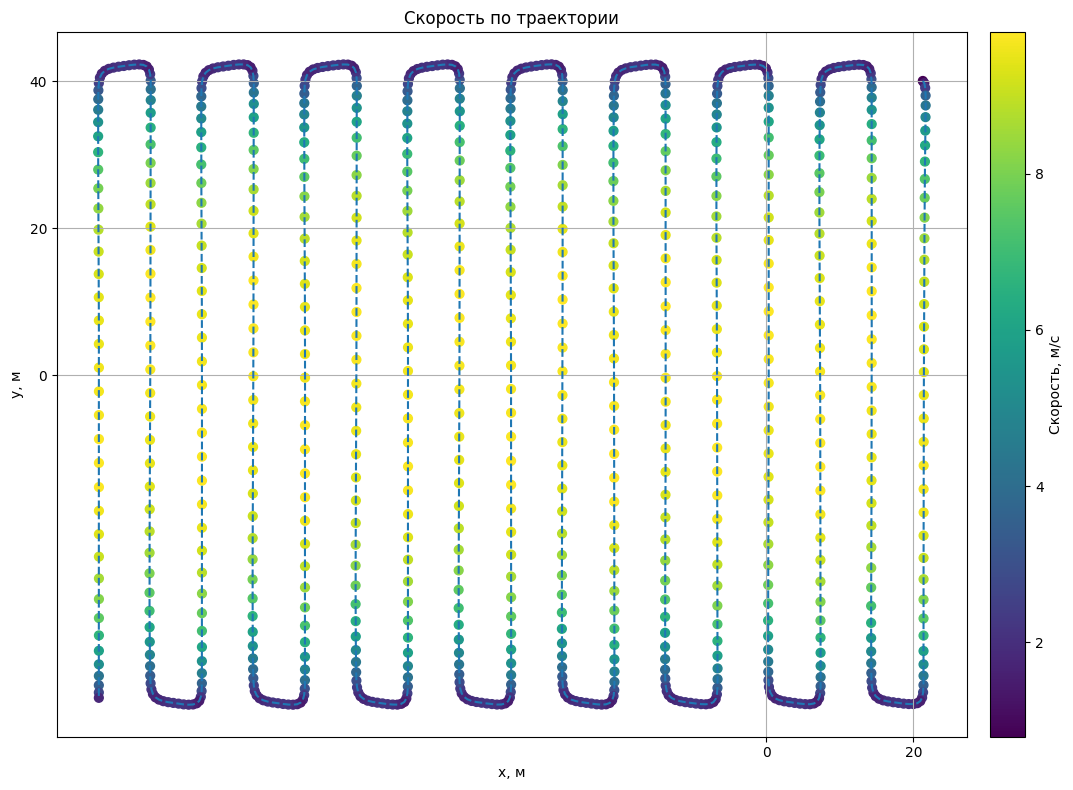

In [119]:
PolylineSampler.plot_trajectory_with_samples(waypoints, s_list, speed_list)

## С дискретизацией по времени

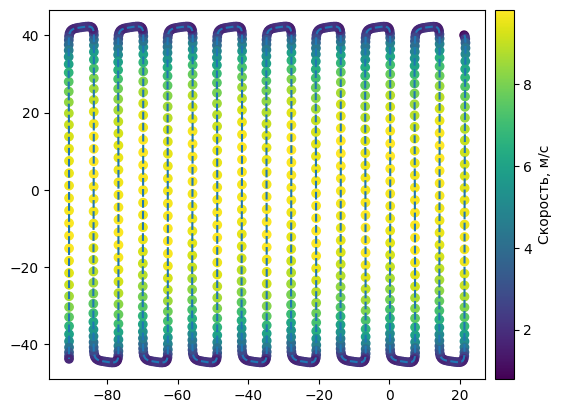

In [120]:
scatter_with_color([point_on_path(waypoints, d) for d in s_list], speed_list)

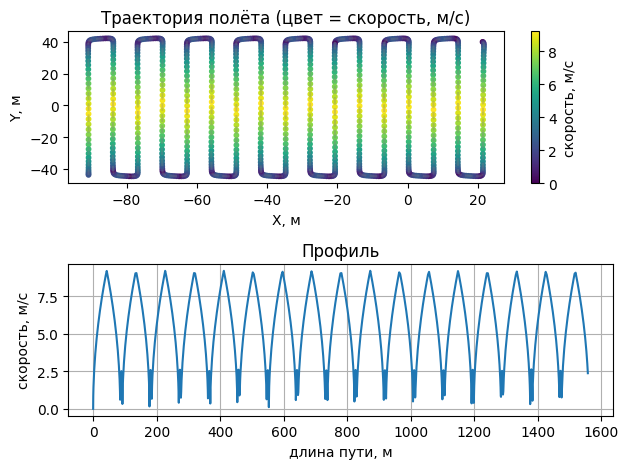

In [121]:
scatter_with_color_and_profile([point_on_path(waypoints, d) for d in s_list],
                               [profile.speed_at_distance(p) for p in s_list])